# EDA: basic

- Descriptive analysis.
- Causality between two numerical variables.
- Identifaing heterogeneity in a variable using samples of the same variable and Wilcoxon test.
- Decission tree to automatic analysis.

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.datasets import load_iris
import pandas as pd
import numpy as np
from scipy.stats import kurtosis
from scipy.stats import skew

## load data

In [2]:
# load dataset
dataset = load_iris()
dataset.keys()
# dataset to df
data = pd.DataFrame(dataset.data, columns = dataset.feature_names)
data['class'] = dataset.target
dclass = dict()
for i, ic in enumerate(dataset.target_names):
    dclass[i] = ic
data['class'] = data['class'].map(dclass)

## df format

In [3]:
# check what columns are NUMERICAL or CATEGORICAL
cols_num = data.select_dtypes(include=['float64', 'int64']).columns.values  # numerical columns
cols_cat = data.select_dtypes(include=['object']).columns.values            # categorical columns
# columns name converters: numerical
dcols_num_name_to_alias = dict()
dcols_num_alias_to_name = dict()
for i, ic in enumerate(cols_num):
    dcols_num_name_to_alias[ic] = 'n{}'.format(i)
    dcols_num_alias_to_name['n{}'.format(i)] = ic
# columns name converters: categorical
dcols_cat_name_to_alias = dict()
dcols_cat_alias_to_name = dict()
for i, ic in enumerate(cols_cat):
    dcols_cat_name_to_alias[ic] = 'c{}'.format(i)
    dcols_cat_alias_to_name['c{}'.format(i)] = ic
# rename columns
data.rename(columns = dcols_num_name_to_alias, inplace = True)
data.rename(columns = dcols_cat_name_to_alias, inplace = True)
# list of alias
cols_num_alias = list(dcols_num_name_to_alias.values())
cols_cat_alias = list(dcols_cat_name_to_alias.values())

# descriptive analysis

### numerical

In [4]:
# describe
dfn = data[cols_num_alias].describe(include = 'all', percentiles = [.05, .25, .5, .75, .95]).T
# add percent of nan values
dfn['%nan'] = (data[cols_num_alias].isnull().sum()*100 / len(data)).values
# kurtosis
dfn['kurtosis'] = kurtosis(data[cols_num_alias])
# skew
dfn['skew'] = skew(data[cols_num_alias])
# rename index
dfn.index = dfn.index.map(dcols_num_alias_to_name)
dfn

,count,mean,std,min,5%,25%,50%,75%,95%,max,%nan,kurtosis,skew
sepal length (cm),150.0,5.843333,0.828066,4.3,4.600,5.1,5.80,6.4,7.255,7.9,0.0,-0.573568,0.311753
sepal width (cm),150.0,3.057333,0.435866,2.0,2.345,2.8,3.00,3.3,3.800,4.4,0.0,0.180976,0.315767
petal length (cm),150.0,3.758000,1.765298,1.0,1.300,1.6,4.35,5.1,6.100,6.9,0.0,-1.395536,-0.272128
petal width (cm),150.0,1.199333,0.762238,0.1,0.200,0.3,1.30,1.8,2.300,2.5,0.0,-1.336067,-0.101934


### categorical

In [5]:
# describe
dfc = data[cols_cat_alias].describe(include = 'all').T[['count', 'unique']]
# add percent of nan values
dfc['%nan'] = (data[cols_cat_alias].isnull().sum()*100 / len(data)).values

In [6]:
## add categories percenets

# maximum number of categories to be showed
max_size_cats = 5
# set columns
col_temp = ['var'] + ['value{}'.format(i) for i in range(max_size_cats)] + ['%value{}'.format(i) for i in range(max_size_cats)]
# initialize
values_temp = list()
# loop of variables
for col in cols_cat_alias:
    # count categories
    temp = data[col].value_counts(normalize=True,sort=True,ascending=False)*100.
    # collect values and names
    c = temp.index.values
    v = temp.values
    # resize
    if len(v) > max_size_cats:
        v = np.append(v[:max_size_cats-1], np.sum(v[-(max_size_cats):]))
        c = np.append(c[:max_size_cats-1], 'others')
    else:
        v = np.pad(v,(0, max_size_cats-len(v)), 'constant', constant_values=np.nan)
        c = np.pad(c,(0, max_size_cats-len(c)), 'constant', constant_values=np.nan)
    # append    
    values_temp.append([col] + list(np.append(c,v)))
# add new information
dfc = pd.concat([dfc, pd.DataFrame(values_temp, columns = col_temp).set_index('var')], axis = 1)
# rename index
dfc.index = dfc.index.map(dcols_cat_alias_to_name)
dfc

,count,unique,%nan,value0,value1,value2,value3,value4,%value0,%value1,%value2,%value3,%value4
var,,,,,,,,,,,,,
class,150,3,0.0,virginica,setosa,versicolor,NaN,NaN,33.333333,33.333333,33.333333,NaN,NaN


# MONOTONIC RELATIONSHIP (non-parametric tests)

Tests whether two samples have a monotonic relationship.

## Spearman's / Kendall's Rank Correlation Test

### Assumptions

- Observations in each sample are independent and identically distributed (iid).
- Observations in each sample can be ranked.

### Interpretation

- H0: the two samples are independent.
- H1: there is a dependency between the samples.

### References

- [MLMastery: 17 Statistical Hypothesis Tests in Python (Cheat Sheet)](https://machinelearningmastery.com/statistical-hypothesis-tests-in-python-cheat-sheet/)

In [12]:
# columns selection
x1_col = cols_num_alias[2]
x2_col = cols_num_alias[3]
# collect data
df = data[[x1_col, x2_col]]
data1 = df[x1_col].values
data2 = df[x2_col].values

In [13]:
# Example of the Spearman's Rank Correlation Test
from scipy.stats import spearmanr

stat, p = spearmanr(data1, data2)
print('stat=%.3f, p=%.5f' % (stat, p))
if p > 0.05:
    print('Probably independent')
else:
    print('Probably dependent')

stat=0.938, p=0.00000
Probably dependent


In [15]:
# Example of the Kendall's Rank Correlation Test
from scipy.stats import kendalltau
stat, p = kendalltau(data1, data2)
print('stat=%.3f, p=%.5f' % (stat, p))
if p > 0.05:
    print('Probably independent')
else:
    print('Probably dependent')

stat=0.807, p=0.00000
Probably dependent


<AxesSubplot:xlabel='n2', ylabel='n3'>

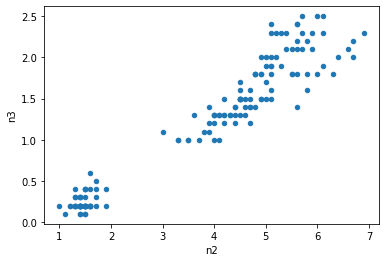

In [16]:
df.plot(kind = 'scatter', x = x1_col, y = x2_col)

# IDENTIFICACION DE HETEROGENEIDAD (non-parametric test for non-paired samples)

## Kruskal-Wallis H Test

Tests whether the distributions of **two or more** independent samples are equal or not.

### Assumptions

- Observations in each sample are independent and identically distributed (iid).
- Observations in each sample can be ranked.

### Interpretation

- H0: the distributions of all samples are equal.
- H1: the distributions of one or more samples are not equal.


In [44]:
def test_kruskal2(data1, data2):
    from scipy.stats import kruskal
    stat, p = kruskal(data1, data2)
    print('stat=%.3f, p=%.3f' % (stat, p))
    if p > 0.05:
        print('Probably the same distribution')
    else:
        print('Probably different distributions')
        
def test_kruskal3(data1, data2, data3):
    from scipy.stats import kruskal
    stat, p = kruskal(data1, data2, data3)
    print('stat=%.3f, p=%.3f' % (stat, p))
    if p > 0.05:
        print('Probably the same distribution')
    else:
        print('Probably different distributions')

### prueba 1: deberia identificarse heterogeneidad

In [40]:
col_num = dcols_num_name_to_alias['petal length (cm)']
col_cat = dcols_cat_name_to_alias['class']

v1 = data[data[col_cat] == 'setosa'][col_num].values
v2 = data[data[col_cat] == 'versicolor'][col_num].values
v3 = data[data[col_cat] == 'virginica'][col_num].values

In [41]:
test_kruskal2(v1, v2)

stat=74.699, p=0.000
Probably different distributions


In [42]:
test_kruskal2(v1, v3)

stat=74.694, p=0.000
Probably different distributions


In [43]:
test_kruskal2(v2, v3)

stat=69.206, p=0.000
Probably different distributions


In [45]:
test_kruskal3(v1, v2, v3)

stat=130.411, p=0.000
Probably different distributions


### prueba 2: no deberia identificarse heterogeneidad

In [50]:
mu = 0; sigma = .1
v = np.random.normal(mu, sigma, 1000)
v1 = v[:600]
v2 = v[600:]
v1.shape, v2.shape

((600,), (400,))

In [51]:
test_kruskal2(v1, v2)

stat=0.621, p=0.431
Probably the same distribution


# TEST IF SAME DISTRIBUTION (non-parametric test for paired samples)

## Wilcoxon Signed-Rank Test

Tests whether the distributions of two paired samples are equal or not.

### Assumptions

- Observations in each sample are independent and identically distributed (iid).
- Observations in each sample can be ranked.
- Observations across each sample are paired.

### Interpretation

- H0: the distributions of both samples are equal.
- H1: the distributions of both samples are not equal.

### References

- [MLMastery: 17 Statistical Hypothesis Tests in Python (Cheat Sheet)](https://machinelearningmastery.com/statistical-hypothesis-tests-in-python-cheat-sheet/)

In [17]:
# Example of the Wilcoxon Signed-Rank Test
def test_wilcoxon(data1:np.array, data2:np.array):
    from scipy.stats import wilcoxon
    stat, p = wilcoxon(data1, data2)
    print('stat=%.5f, p=%.5f' % (stat, p))
    if p > 0.05:
        print('Probably the same distribution')
    else:
        print('Probably different distributions')

### prueba 1: 2 samples de una misma distribucion normal (homegeneidad)

In [28]:
mu = 0; sigma = .1
v1 = np.random.normal(mu, sigma, 100)
v2 = np.random.normal(mu, sigma, 100)

In [29]:
test_wilcoxon(v1, v2)

stat=2310.00000, p=0.45976
Probably the same distribution


### prueba 2: 2 samples de dos distribuciones normales muy parecidas pero no iguales (heterogeneidad)

In [30]:
mu1 = 0; sigma1 = .1
mu2 = 0.05; sigma2 = .1
v1 = np.random.normal(mu1, sigma1, 1000)
v2 = np.random.normal(mu2, sigma2, 1000)

In [31]:
test_wilcoxon(v1, v2)

stat=141390.00000, p=0.00000
Probably different distributions


# Decission Tree for automatic analysis

https://scikit-learn.org/stable/modules/tree.html#tree

In [65]:
from sklearn.tree import DecisionTreeClassifier as Tree
from sklearn import tree

In [16]:
# data selection
X = data[cols_num_alias].values
y = data[cols_cat_alias].values.ravel()

In [55]:
clf = Tree(max_depth =4, random_state = 42, min_samples_leaf = 0.1, criterion = "gini")
clf.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=0.1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

In [56]:
cols_cat_alias[0]

'c0'

In [62]:
dot_data = tree.export_graphviz(clf, out_file=None, 
                                feature_names=cols_num, 
                                class_names=dataset.target_names,
                                filled=True)

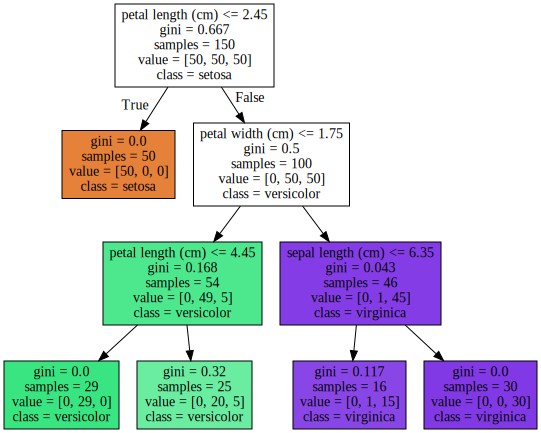

In [63]:
import graphviz
# Draw graph
graph = graphviz.Source(dot_data, format="png") 
graph